# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [1]:
%matplotlib inline

In [2]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from dateutil.parser import parse

In [3]:
DATA_FOLDER = './data/'

# Homework Assignment 1, prayingmantissa


- Roman Bachman, roman.bachman@epfl.ch
- Michael Allemann, michael.allemann@epfl.ch
- Andrea Caforio, andrea.caforio@epfl.ch

# Task 1, Compiling Ebola Data

## ASSUMPTIONS
 - We solely concentrated our effort on confirmed numbers. The reason herefor is that there is no way to know, if a patient, previously registered as a suspected case, gets counted again when his illness is confirmed to be ebola. Analogous for the deaths, likely on one day a death gets registered as potentially ebola and days later after more thorough medical analysis it is confirmed to have been ebola, so another death gets counted in the confirmed cases.
 - Empty cells in the wanted attributes are treated as invalid data and exluded from the statistic since there are no indications that an empty cell is identical to zero.
 - In the same spirit we excluded the december sheets for Liberia due to abnormally large values, which do not correspond to the actual events. [Source](https://en.wikipedia.org/wiki/Ebola_virus_epidemic_in_Liberia#/media/File:West_Africa_Ebola_2014_10_Reported_Cases_per_Week_Liberia.png)
 - The daily average per month is calculated as:
 
     $$avg(i) = \frac{1}{\sum_{d_j \in D_i} \mathbb{1}_{d_j \geq 0}} \sum_{d_j \in D_i} d_j * \mathbb{1}_{d_j \geq 0}$$
     where $D_i$ are the case numbers of the i-th month
   
 - Since there is a large sparsity of data in some months we appended the number of valid data sheets per month and country as a separate column to the DataFrame to allow the user to draw his own conclusions on how he is going to interpret the average values.

## EXECUTION
 - The csv files are noisey and contain a lot of unwanted characters that make the type inference difficult. Regexes are applied to counter the most prevalent cases like dangling percent characters or inserted commas.
 - A for-loop routine is used for each country that extracts and parses the month, new and deaths cases from the csv files and appends them to preallocated DataFrame.
 - Special care has to be given to the Sierra Leone data sheets. They do not provide the daily death cases but only an accumulative digit over several months. We circumvent this issue by taking the difference betweent two data points as seen inside the for-loop.
 - A simple group by operation over the two index attributes (Month, Country) suffices to yield the specified daily average per month and country.

In [4]:
ebola = pd.DataFrame(columns=['Month', 'Country', 'New', 'Deaths'])
ebola['Month'] = ebola['Month'].astype(np.int64)
ebola['New'] = ebola['New'].astype(np.int64)
ebola['Deaths'] = ebola['Deaths'].astype(np.int64)

def ebola_dirs(dirname, country, totals_col, new_id, deaths_id):
    global ebola
    
    path = DATA_FOLDER + 'ebola/' + dirname
    
    acc_deaths = 0
    for csv in sorted(os.listdir(path)):
        frame = pd.read_csv(path + '/' + csv, index_col=[1]).fillna(-1)
        frame[totals_col].replace('%', '', regex=True, inplace=True)
        frame[totals_col].replace(',', '', regex=True, inplace=True)
        frame[totals_col].replace('\..*', '', regex=True, inplace=True)
        frame[totals_col] = frame[totals_col].astype(np.int64)
        
        if country == 'Liberia' and '2014-12' in csv:
            continue
        
        deaths_id_mod = deaths_id
        if country == 'Guinea' and csv == '2014-08-04.csv':
            deaths_id_mod += ' today'

        month = parse(frame[frame.columns[0]][1]).month
        new = frame.loc[new_id][totals_col]
        deaths = frame.loc[deaths_id_mod][totals_col]
        
        if new < 0 or deaths < 0:
            continue
        
        if country == 'Sierra Leone':
            tmp = deaths
            deaths = deaths - acc_deaths
            acc_deaths = tmp
        
        row = pd.DataFrame({'Month': month, 'Country': country, 'New': [new], 'Deaths': [deaths]})
        ebola = ebola.append(row)

ebola_dirs('guinea_data/', 'Guinea', 'Totals', 'New cases of confirmed', 'New deaths registered')
ebola_dirs('liberia_data/', 'Liberia', 'National', 'New case/s (confirmed)', 'Newly reported deaths')
ebola_dirs('sl_data/', 'Sierra Leone', 'National', 'new_confirmed', 'death_confirmed')

ebola.groupby(['Month', 'Country']).agg({'New': np.mean, 'Deaths': [np.mean, np.size]})

New     Deaths     
                         mean       mean size
Month Country                                
6     Liberia        2.142857   2.000000    7
7     Liberia        1.818182   4.272727   11
8     Guinea        12.400000   3.400000    5
      Liberia        5.444444  23.222222    9
      Sierra Leone  20.611111  21.500000   18
9     Guinea        13.000000   3.562500   16
      Liberia        6.217391  37.608696   23
      Sierra Leone  36.962963   6.037037   27
10    Guinea         6.000000  15.000000    1
      Liberia        1.619048  27.666667   21
      Sierra Leone  56.714286  18.571429   28
11    Liberia        7.333333  14.333333    3
      Sierra Leone  66.210526  22.421053   19
12    Sierra Leone  54.333333  57.666667    3

# Task 2, RNA Sequences

## ASSUMPTIONS
 - The bacteria type strings do not suffice as a primary indexes, we therefore use an incremental counter in combination with the file names, MID1 to MID9 as a new index structure.
 - The number attribute that can differ from one file to another is considered to be identical throughout the data sheets.

## EXECUTION
- As in the first exercise a simple for loop suffices to read in the excel files. The bacteria type and number fields are unified.
- To facilitate the join with the metadata frame with append the barcode as a separate column to the RNA data frame. This barcode fields is then dropped from the final table as it is already present as part of the index.

In [5]:
# Task 2

rna = pd.DataFrame()

for i in range(1, 10):
    file = 'MID' + str(i)
    frame = pd.read_excel(DATA_FOLDER + '/microbiome/' + file + '.xls')
    frame.columns = ['TYPE', 'NUMBER']
    frame['BARCODE'] = file
    frame.index = list(map(lambda n: file + '_' + str(n), np.arange(1, len(frame)+1)))
    rna = pd.concat([rna, frame])
    
meta = pd.read_excel(DATA_FOLDER + '/microbiome/metadata.xls', index_col=0)

rna.join(meta, on="BARCODE").drop('BARCODE', axis=1).fillna('unknown')

,TYPE,NUMBER,GROUP,SAMPLE
MID1_1,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",2,EXTRACTION CONTROL,unknown
MID1_2,"Archaea ""Crenarchaeota"" Thermoprotei Sulfoloba...",3,EXTRACTION CONTROL,unknown
MID1_3,"Archaea ""Crenarchaeota"" Thermoprotei Thermopro...",3,EXTRACTION CONTROL,unknown
MID1_4,"Archaea ""Euryarchaeota"" ""Methanomicrobia"" Meth...",7,EXTRACTION CONTROL,unknown
MID1_5,"Archaea ""Euryarchaeota"" ""Methanomicrobia"" Meth...",1,EXTRACTION CONTROL,unknown
MID1_6,"Archaea ""Euryarchaeota"" ""Methanomicrobia"" Meth...",1,EXTRACTION CONTROL,unknown
MID1_7,"Archaea ""Euryarchaeota"" Archaeoglobi Archaeogl...",1,EXTRACTION CONTROL,unknown
MID1_8,"Archaea ""Euryarchaeota"" Archaeoglobi Archaeogl...",1,EXTRACTION CONTROL,unknown
MID1_9,"Archaea ""Euryarchaeota"" Halobacteria Halobacte...",1,EXTRACTION CONTROL,unknown
MID1_10,"Archaea ""Euryarchaeota"" Halobacteria Halobacte...",4,EXTRACTION CONTROL,unknown


# Task 3, Class War on the Titanic

## Assumptions
1. In a broad sense ticket, cabin and boat can also be considered as categories because they can be shared by several passengers. However, we wanted to limit the number of possible discrete bins which would not be possible with the above attributes.
2. Self explanatory.
3. The first name of the cabin string dictates the floor
4. Self explanatory.
5. Self explanatory.
6. Self explanaorry.

## Execution
1. -
2. From left to right, we plot the histogram for the travel class, embarkation port, sex and age. We decided to only plot the rows for which we have data available. The value_counts function works wonder here.
3. First drop all entries with nan cabin values the map out the first letter for the value_counts function.
4. When leaving the survived attribute as integers 0 and 1 we can conveniently use an aggregator.
5. Same thing applies here.
6. After sorting the DataFrame by age and dropping all nans we can use pandas qcut to divide the rows in two almost equally sized categories. As there are 32 people that have the median age of 28, we decided to count them all to the young group. This results in the young and old group not having the exact same number of members. Like this, there are 536 young and 510 old people, meaning that we have a delta of +- 13 people in each category, compared to the group size if we made the two groups the exact same size. We finalize by using the same aggregator as in the previous exercises.

In [170]:
titanic = pd.read_excel(DATA_FOLDER + '/titanic.xls')

## 3.1

| Attribute     | Type     | Range         | Categorical     | Remarks
|---------------|----------|---------------|-----------------|---------------------------------
|pclass         |int64     |[1, 3]         |Yes              |-
|survived       |int64     |[0, 1]         |Yes              |Not casted to simplify calculations
|name           |object    |-              |No               |-
|sex            |object    |{male, female} |Yes              |-
|age            |float64   |[0.1667, 80.0] |No               |-
|sibsp          |int64     |[0, 8]         |No               |-
|parch          |int64     |[0, 9]         |No               |-
|ticket         |object    |-              |No               |-
|fare           |float64   |[0.0, 512.33]  |No               |-
|cabin          |object    |-              |No               |-
|embarked       |object    |{S, C, Q}      |Yes              |-
|boat           |object    |-              |No               |-
|body           |float64   |[1.0, 328.0]   |No               |-
|home.dest      |object    |-              |No               |-

In [142]:
titanic.pclass = titanic.pclass.astype('category')
titanic.sex = titanic.sex.astype('category')
titanic.embarked = titanic.embarked.astype('category')

## 3.2

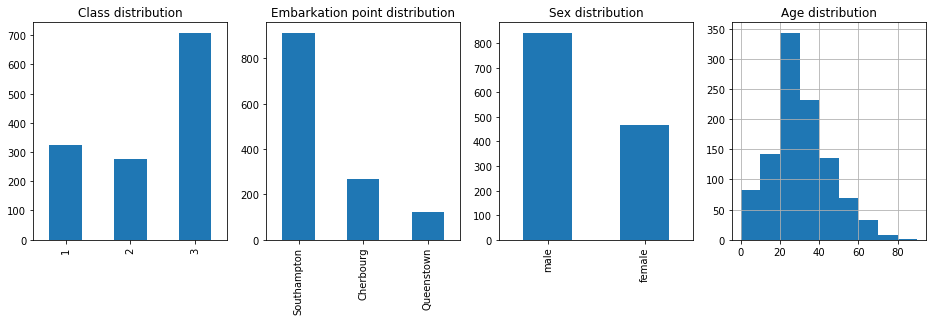

In [219]:
plt.figure(figsize=(16, 4))

plt.subplot(141)
tc = titanic.pclass.value_counts().sort_index().plot(kind='bar', title='Class distribution')

titanic.embarked.replace(['S', 'C', 'Q'], ['Southampton', 'Cherbourg', 'Queenstown'], inplace=True)
plt.subplot(142)
em = titanic.embarked.value_counts().plot(kind='bar', title='Embarkation point distribution')

plt.subplot(143)
sx = titanic.sex.value_counts().plot(kind='bar', title='Sex distribution')

plt.subplot(144)
plt.title('Age distribution')
ae = titanic.age.hist(bins=np.arange(0, 100, 10))

## 3.3

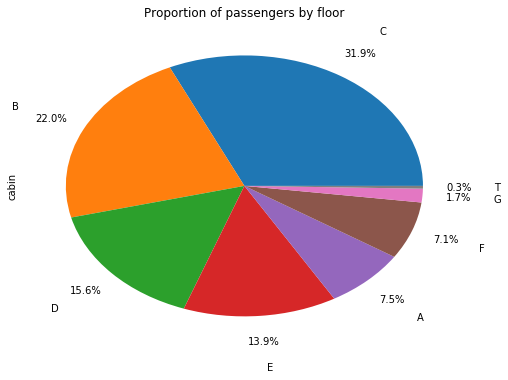

In [213]:
plt.figure(figsize=(8, 6))

titanic.cabin.dropna() \
    .map(lambda cf: str(cf)[0]) \
    .value_counts() \
    .plot.pie(title='Proportion of passengers by floor', autopct='%.1f%%', pctdistance=1.2, labeldistance=1.4)

## 3.4

([<matplotlib.patches.Wedge at 0x11f077c50>,
  <matplotlib.text.Text at 0x11f087ac8>])

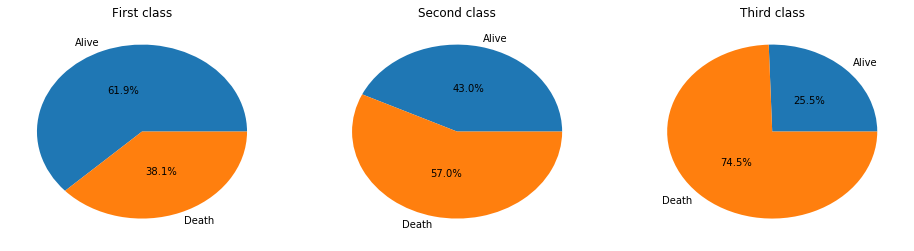

In [195]:
sv = titanic[['pclass', 'survived']].groupby('pclass').mean()
plt.figure(figsize=(16, 4))

plt.subplot(131)
plt.title('First class')
plt.pie([sv.iloc[0], 1 - sv.iloc[0]],
        labels=['Alive', 'Death'], autopct='%.1f%%', pctdistance=0.5, labeldistance=1.1)

plt.subplot(132)
plt.title('Second class')
plt.pie([sv.iloc[1], 1 - sv.iloc[1]],
        labels=['Alive', 'Death'], autopct='%.1f%%', pctdistance=0.5, labeldistance=1.1)

plt.subplot(133)
plt.title('Third class')
plt.pie([sv.iloc[2], 1 - sv.iloc[2]],
        labels=['Alive', 'Death'], autopct='%.1f%%', pctdistance=0.5, labeldistance=1.1)

## 3.5

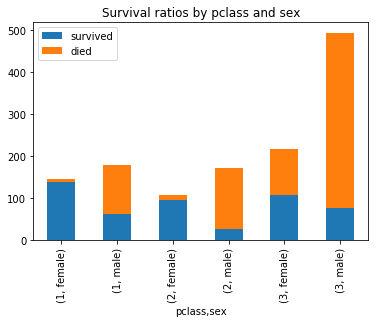

In [194]:
sv = titanic[['survived', 'pclass', 'sex']].groupby(['pclass', 'sex']).sum()
st = titanic[['pclass', 'sex']].groupby(['pclass', 'sex']).size()
sv['died'] = st-sv.survived
sv.plot.bar(stacked=True, title='Survival ratios by pclass and sex')

## 3.6

In [222]:
cat = titanic.sort_values('age')[['age', 'survived', 'sex', 'pclass']].dropna()
cat['cat'] = pd.qcut(cat['age'], 2, labels=['young', 'old'])
cat = cat[['cat', 'survived', 'pclass', 'sex']]
cat.groupby(['pclass', 'sex', 'cat']).mean()

survived
pclass sex    cat            
1      female old    0.967391
              young  0.951220
       male   old    0.302521
              young  0.531250
2      female old    0.872340
              young  0.910714
       male   old    0.083333
              young  0.216216
3      female old    0.372093
              young  0.513761
       male   old    0.144000
              young  0.183036